# Project 3: Recommender Systems

##### Group Member
Yifu Yuan, 804973353  
Zhiquan You, 205667859  
Wenxuan Wu, 705846929

### QUESTION 1: Explore the Dataset:

##### A. Compute the sparsity of the movie rating dataset:

In [1]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 7.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630071 sha256=20f04ffb9275b52b66a895e6cd8459a06da537ae4b9f86900770bcc4ba509dd6
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise import Dataset, Reader, accuracy
from sklearn import metrics
from surprise.prediction_algorithms.matrix_factorization import NMF
from tqdm import tqdm
from collections import Counter

In [3]:
def plot_line(x, y, xlabel, ylabel, title):

  plt.plot(x, y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.show()


In [4]:
def plot_bar(x, y, xtick, xlabel, ylabel, title):

  plt.bar(x, y, width=0.5)
  plt.xticks(xtick)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.title(title)

  plt.show()

In [8]:
rating_file = pd.read_csv('ratings.csv');
print(rating_file)

userId = rating_file['userId']
movieId = rating_file['movieId']
rating = rating_file['rating']

unique_user = set(userId)
unique_movie = set(movieId)

#print(len(userId), len(movieId), len(rating), len(set(movieId)), len(set(userId)))

sparsity = len(rating) / (len(unique_user) * len(unique_movie))

print("Sparcity of rating dataset is: " , sparsity)

        Unnamed: 0  userId  movieId  rating   timestamp
0                0     496   112852     3.0  1415520462
1                1     391     1947     4.0  1030945141
2                2     387     1562     1.5  1095041022
3                3     474     2716     4.5  1053020930
4                4     483    88125     4.5  1311337237
...            ...     ...      ...     ...         ...
100831      100831     469     1219     4.0   965661925
100832      100832     599     3571     2.0  1498511343
100833      100833     414      276     3.0   961596299
100834      100834     395      168     3.0   841503984
100835      100835     288     2407     3.5  1054568795

[100836 rows x 5 columns]
Sparcity of rating dataset is:  0.016999683055613623


##### B. Plot a histogram showing the frequency of the rating values:

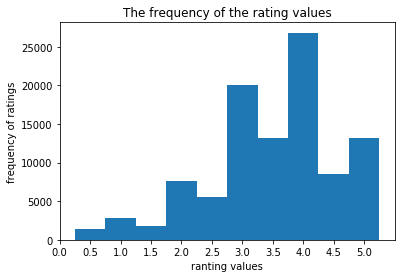

In [ ]:
# list_of_unique_ratings = list(set(ratings))
unique, counts = np.unique(rating, return_counts=True)

plot_bar(x=unique, y=counts, xtick=np.arange(0, 5.5, step=0.5), xlabel='ranting values', ylabel='frequency of ratings', title='The frequency of the rating values')


As we can observe from the graph, the chart is skewed to the left, which indicates that most users give higher ratings for movies, ranging from 3.0 to 5.0. 

##### C. Plot the distribution of the number of ratings received among movies:

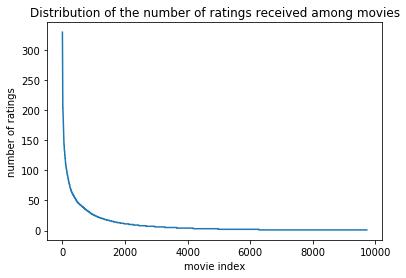

In [ ]:
unique, counts = np.unique(movieId, return_counts=True)

plot_line(x=range(1, len(unique) + 1), y=-np.sort(-counts), 
          xlabel='movie index', ylabel='number of ratings', title='Distribution of the number of ratings received among movies')

##### D. Plot the distribution of ratings among users:

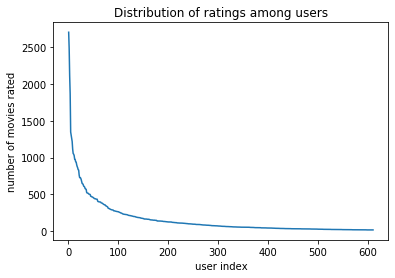

In [ ]:
unique, counts = np.unique(userId, return_counts=True)

plot_line(x=range(1, len(unique) + 1), y=-np.sort(-counts), 
          xlabel='user index', ylabel='number of movies rated', title='Distribution of ratings among users')

##### E. Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

As we can see from the graph, there are only a small portions of movies that receives relatively enough ratings from the users, while the majority of the movies barely have any. For movies, over 95% of them only receive no more than 25 ratings and for users, over 80% of them rated no more than 300 movies while there exist 9742 movie in the dataset. Therefore, the rating matrix for the recommendation system will be very sparse. From our perspective, we think that the recommender system will just recommend to the users only the subsets of the movies coming from the ones that have enough ratings, while the rest of the hardly rated movies would contribute little or no information to the training model, which will result in poor performance on these movies.

##### F. Compute the variance of the rating values received by each movie:

movieId
1         0.693748
2         0.770351
3         1.091254
4         0.622449
5         0.806122
            ...   
193581    0.000000
193583    0.000000
193585    0.000000
193587    0.000000
193609    0.000000
Name: rating, Length: 9724, dtype: float64


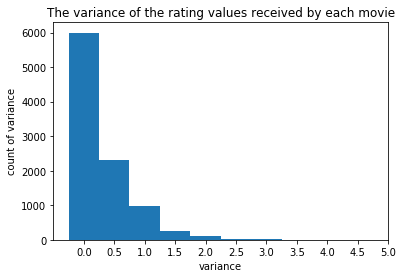

In [ ]:
movies = rating_file.groupby(by='movieId')
variance = movies['rating'].var(ddof=0)
print(variance)
bin=np.arange(0, 5.5, 0.5)
label_size = len(bin)
var_bins = pd.cut(variance, bins=bin, right=False, labels=bin[0: label_size - 1])
val, counts = np.unique(var_bins, return_counts=True)

plot_bar(x=val, y=counts, xtick=bin, xlabel='variance', 
         ylabel='count of variance', title='The variance of the rating values received by each movie')

We can observe that our graph is skewed to the right with the majority of variance 0, meaning that the ratings given by the users to certain movies do not vary much. This corresponds to the frequency of rating values histogram where majority of the users give 3 - 5 ratings for movies.

### QUESTION 2: Understanding the Pearson Correlation Coefficient:

##### A. Write down the formula for $µ_{u}$ in terms of $I_{u}$ and $r_{uk}$;

Since we know that $I_{u}$ is the set of indices that user u has specified the rating for and $r_{uk}$ is the rating value for a specific item at index k. We can just sum up all the rating values for item indexed in $I_{u}$ and divided by the length of $I_{u}$ to get the mean $µ_{u}$. The formula is:

\begin{align}
        \mu_{u} = \frac{\sum\nolimits_{k \in I_{u}} \, r_{uk}}{|I_{u}|}
    \end{align}



##### B. In plain words, explain the meaning of $I_{u}$ ∩ $I_{v}$. Can $I_{u}$ ∩ $I_{v}$ = ∅? (Hint: Rating matrix R is sparse)

The meaning of $I_{u}$ ∩ $I_{v}$ is the set of movies that have been rated by both the user u and user v. $I_{u}$ ∩ $I_{v}$ can be ∅ since there could be some movies that are rated by user u but not rated by user v, or vice versa.

### QUESTION 3: Understanding the Prediction function:

##### Can you explain the reason behind mean-centering the raw ratings ($r_{vj}$ - $u_{v}$) in the prediction function?

The reason behind mean-centering the raw ratings in the prediction functions could be that it helps reduce certain bias and extreme ratings to improve prediction result. For example, some users might be polarized that they rate the movies either extremely high or extremely low and that is biased and noisy for the data set. By subtracting their expected means for the movies, we can get a better sense of how these users rate the movies. 

### QUESTION 4: Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation.  

In [9]:
# pd_dataset = pd.read_csv("ratings.csv", usecols = ['userId','movieId','rating','timestamp'])
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1, rating_scale=(1, 5))
ratings_dataset = Dataset.load_from_df(rating_file[['userId','movieId','rating']], reader)

In [ ]:
k_range = np.arange(2, 102, 2)
avg_rmse = []
avg_mae = []

for k in tqdm(k_range):
  result = cross_validate(KNNWithMeans(k=k, sim_options={'name':'pearson'}, verbose=False), data=ratings_dataset, measures=['RMSE', 'MAE'],cv=10)
  avg_rmse.append(np.mean(result['test_rmse']))
  avg_mae.append(np.mean(result['test_mae']))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:08<00:00, 13.37s/it]


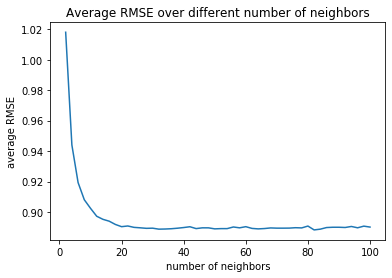

In [ ]:
plot_line(x=k_range, y=avg_rmse, xlabel="number of neighbors", 
          ylabel="average RMSE", title="Average RMSE over different number of neighbors")

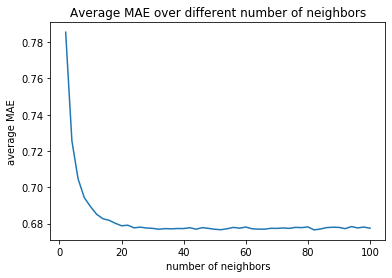

In [ ]:
plot_line(x=k_range, y=avg_mae, xlabel="number of neighbors", 
          ylabel="average MAE", title="Average MAE over different number of neighbors")

### QUESTION 5: Use the plot from question 4, to find a ’minimum k’. Please report the steady state values of average RMSE and average MAE.

In [ ]:
# step size is 2
print('average RMSE: ', avg_rmse[9])
print('average MAE: ', avg_mae[9])

average RMSE:  0.8904025589640983
average MAE:  0.678781904601043


From our graphes, we can observe that when number of neighbors reaches 20, the average MAE and RMSE would not fluctuate much, meaning these converge to a steady state. The corresponding value for average RMSE at 20 is around 0.89, and the corresponding value for average MAE at 20 is around 0.68.

### QUESTION 6: For EACH of the 3 subsets in the test set, design: A k-NN collaborative filter to predict the ratings of the movies in the test subset (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:



*   Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute
the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE
(Y-axis) against k (X-axis). Also, report the minimum average RMSE.






*    Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. For
each of the plots, also report the area under the curve (AUC) value.






In [10]:
def trim_test(test_set, dictionary, condition):
    return [i for i in test_set if eval(condition)]

In [11]:
def load_dictionary(dataset):
  dictionary = dict()
  for i in dataset.raw_ratings:
    if i[1] not in dictionary:
        dictionary[i[1]] = []
        dictionary[i[1]].append(i[2])
    else: 
        dictionary[i[1]].append(i[2])

  return dictionary

##### For Popular movie trimming:

In [ ]:
kf = KFold(n_splits=10)
avg_rmse_pop = []

dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) > 2')
    result = KNNWithMeans(k=k, sim_options={'name':'pearson'}, verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  avg_rmse_pop.append(np.mean(rmse));



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:50<00:00, 14.22s/it]


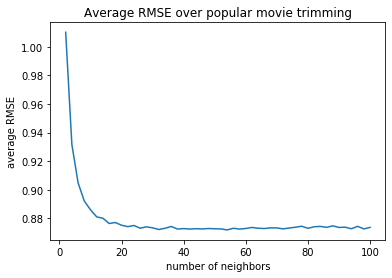

minimum average RMSE is:  0.8719673239040912


In [ ]:
plot_line(x=k_range, y=avg_rmse_pop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over popular movie trimming")

print("minimum average RMSE is: ", min(avg_rmse_pop))

##### For unpopular movie triming

In [ ]:
kf = KFold(n_splits=10)
avg_rmse_unpop = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) <= 2')
    result = KNNWithMeans(k=k, sim_options={'name':'pearson'}, verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  avg_rmse_unpop.append(np.mean(rmse));

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:58<00:00,  8.36s/it]


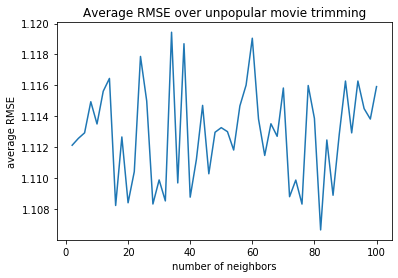

minimum average RMSE is:  1.1066555609389828


In [ ]:
plot_line(x=k_range, y=avg_rmse_unpop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over unpopular movie trimming")

print("minimum average RMSE is: ", min(avg_rmse_unpop))

##### For High variance movie trimming

In [ ]:
kf = KFold(n_splits=10)
avg_rmse_high_var = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
    result = KNNWithMeans(k=k, sim_options={'name':'pearson'},verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  avg_rmse_high_var.append(np.mean(rmse));

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:04<00:00, 12.09s/it]


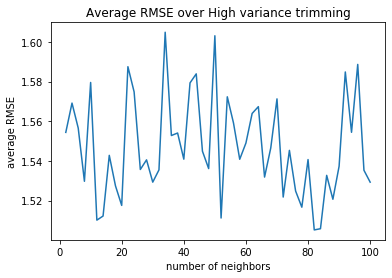

minimum average RMSE is:  1.5051828995171241


In [ ]:
plot_line(x=k_range, y=avg_rmse_high_var, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over High variance trimming")

print("minimum average RMSE is: ", min(avg_rmse_high_var))

##### ROC curves for popular trimming



In [ ]:
threshold = [2.5, 3, 3.5, 4]

dictionary = load_dictionary(ratings_dataset)

train_pop, test_pop = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
test = trim_test(test_pop, dictionary, 'len(dictionary[i[1]]) > 2')  
knn_pred_pop = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train_pop).test(test)

In [ ]:
for i in range(5):
  print(knn_pred_pop[i])

user: 292        item: 3450       r_ui = 3.00   est = 3.32   {'actual_k': 20, 'was_impossible': False}
user: 105        item: 60684      r_ui = 3.50   est = 4.61   {'actual_k': 20, 'was_impossible': False}
user: 52         item: 52281      r_ui = 4.00   est = 4.71   {'actual_k': 15, 'was_impossible': False}
user: 299        item: 3578       r_ui = 5.00   est = 3.79   {'actual_k': 20, 'was_impossible': False}
user: 57         item: 6          r_ui = 3.00   est = 4.07   {'actual_k': 20, 'was_impossible': False}


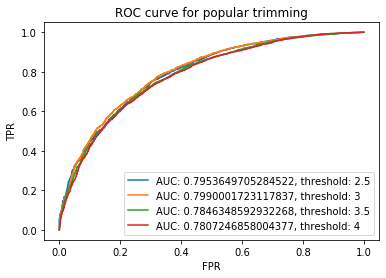

In [ ]:
for thres in threshold:
  y_true = []
  for i in knn_pred_pop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in knn_pred_pop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for popular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

  

##### ROC curves for unpopular trimming



In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_unpop, test_unpop = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
test = trim_test(test_unpop, dictionary, 'len(dictionary[i[1]]) <= 2')
knn_pred_unpop = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train_unpop).test(test)

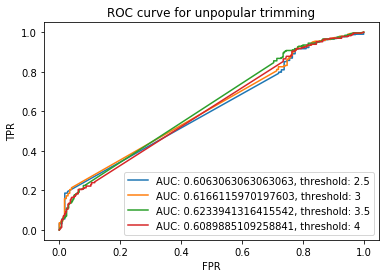

In [ ]:
for thres in threshold:
  y_true = []
  for i in knn_pred_unpop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in knn_pred_unpop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for unpopular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

##### ROC curves for high variance trimming



In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_var, test_var = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
test_var = trim_test(test_var, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
knn_pred_var = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train_var).test(test_var)

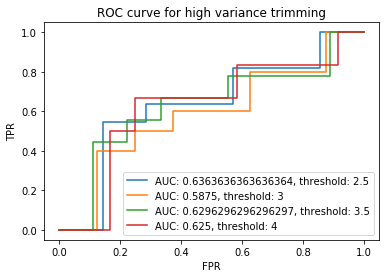

In [ ]:
for thres in threshold:
  y_true = []
  for i in knn_pred_var:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in knn_pred_var]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for high variance trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

### QUESTION 7: Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

No, the optimization problem given by equation 5 is not convex. 
As we can see from the equation \begin{align}
        min_{U,V}{\sum_{i=1}^{m}\sum_{j=1}^{n} \, W_{ij}}{(r_{ij} - (UV^T)_{ij})^2}
    \end{align}
  We can just take its simplest form which is 
  \begin{align}
        {\Delta LF(U, V)} = {W}{(r - (UV))^2}
    \end{align}

  and take the Hessian matrix of it with respect to the U and V,

  
  \begin{bmatrix} 
        \frac{\partial LF}{\partial U}\\
        \frac{\partial LF}{\partial V}
\end{bmatrix} 
    
\begin{bmatrix}
      {-2W(r-UV)V}\\
      {-2W(r-UV)U}
  \end{bmatrix} 
  


  \begin{bmatrix}
    {2WV^2} && {-2W(r-2UV)} \\
    {-2W(2VU-r)} && {2WU^2}
\end{bmatrix} 


The determinant of this matrix would be  \begin{align} {4W^2V^2U^2 - 4W^2(r-2UV)^2} = {4W^2(V^2U^2-r^2+4UVr-4U^2V^2)} = {4W^2(-3U^2V^2-r^2+4UVr)} \end{align}
which is not positive for all values of r, U, V. As the definition stated, a function f is convex, if its Hessian is everywhere positive semi-definite. Therefore, it is not convex. 


For U fixed, the least-squares formulation would be \begin{align} min_{V}∑_{i=1}^{m}∑_{j=1}^{n}W_{ij}(r_{ij} - (UV^T)_{ij})^2\end{align}


### QUESTION 8: Designing the NMF Collaborative Filter:

##### A. Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation.

In [ ]:
k_nmf_range = np.arange(2, 52, 2)
nmf_avg_rmse = []
nmf_avg_mae = []

for k in tqdm(k_nmf_range):
  result = cross_validate(NMF(n_factors=k,verbose=False), data=ratings_dataset, measures=['RMSE', 'MAE'], cv=10)
  nmf_avg_rmse.append(np.mean(result['test_rmse']))
  nmf_avg_mae.append(np.mean(result['test_mae']))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [27:40<00:00, 66.42s/it]


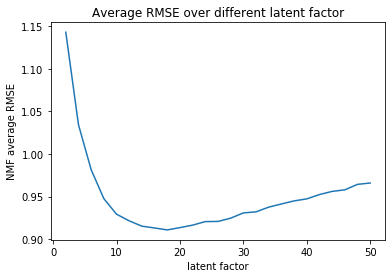

In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse, xlabel="latent factor", 
          ylabel="NMF average RMSE", title="Average RMSE over different latent factor")

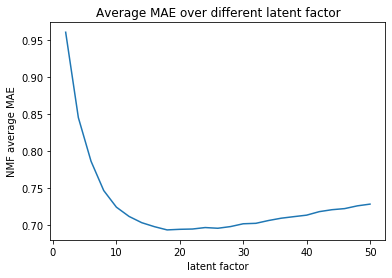

In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_mae, xlabel="latent factor", 
          ylabel="NMF average MAE", title="Average MAE over different latent factor")

##### B. Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

In [ ]:
rmse_min_index = nmf_avg_rmse.index(min(nmf_avg_rmse))
mae_min_index = nmf_avg_mae.index(min(nmf_avg_mae))

print("the minimum NMF RMSE is: ", min(nmf_avg_rmse), " and the optimum number of latent factors are: ", k_nmf_range[rmse_min_index])
print("the minimum NMF MAE is: ", min(nmf_avg_mae), " and the optimum number of latent factors are: ", k_nmf_range[mae_min_index])

the minimum NMF RMSE is:  0.9109420076108362  and the optimum number of latent factors are:  18
the minimum NMF MAE is:  0.6933099873304771  and the optimum number of latent factors are:  18


In [ ]:
df_movie = pd.read_csv('movies.csv');
df_movie['genres']

arr_of_genres = []
for i in df_movie['genres']:
  for j in i.split('|'):
    if j not in arr_of_genres:
      arr_of_genres.append(j)

print(arr_of_genres)
print(len(arr_of_genres))


['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']
20


As we can see, we have 20 genres of movies which is the same as the optimum number of latent factors for the minimum NMF MAE.

##### C. Performance on trimmed Test set subsets: For each of Popular, Unpopular and HighVariance test subsets



*   Design a NMF collaborative filter to predict the ratings of the movies in the trimmed test
subset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE
obtained by averaging the RMSE across all 10 folds.
*   Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.



In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_pop = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_nmf_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) > 2')
    result = NMF(n_factors=k,verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_pop.append(np.mean(rmse));

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [27:56<00:00, 67.05s/it]


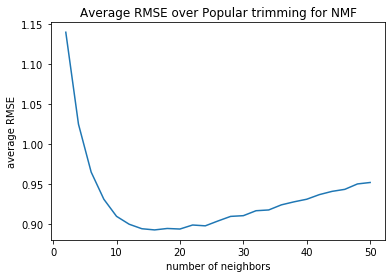

minimum average RMSE is:  0.8930986904176231


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_pop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over Popular trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_pop))

In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_unpop = []
dictionary = load_dictionary(ratings_dataset)

for k in k_nmf_range:
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) <= 2')
    result = NMF(n_factors=k,verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_unpop.append(np.mean(rmse))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


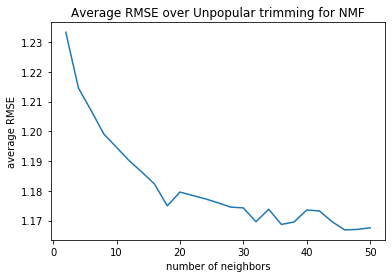

minimum average RMSE is:  1.1668757444726907


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_unpop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over Unpopular trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_unpop))

In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_var = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_nmf_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
    result = NMF(n_factors=k,verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_var.append(np.mean(rmse))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [29:13<00:00, 70.15s/it]


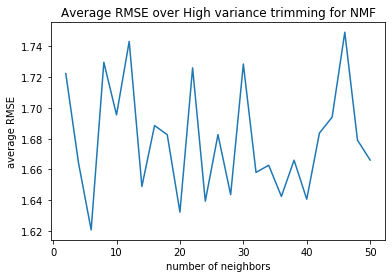

minimum average RMSE is:  1.6207799625691326


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_var, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over High variance trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_var))

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_pop_nmf, test_pop_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_pop_nmf, dictionary, 'len(dictionary[i[1]]) > 2')
nmf_pred_pop = NMF(n_factors=20,verbose=False).fit(train_pop_nmf).test(trimmed_test)

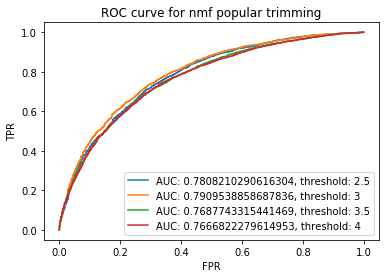

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_pop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_pop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf popular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_unpop_nmf, test_unpop_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_unpop_nmf, dictionary, 'len(dictionary[i[1]]) <= 2')
nmf_pred_unpop = NMF(n_factors=20,verbose=False).fit(train_unpop_nmf).test(trimmed_test)

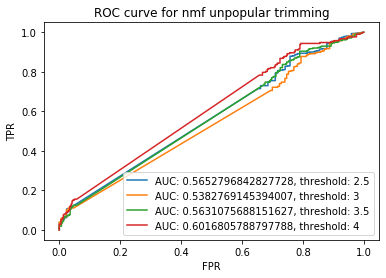

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_unpop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_unpop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf unpopular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_var_nmf, test_var_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_var_nmf, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
nmf_pred_var = NMF(n_factors=20,verbose=False).fit(train_var_nmf).test(trimmed_test)

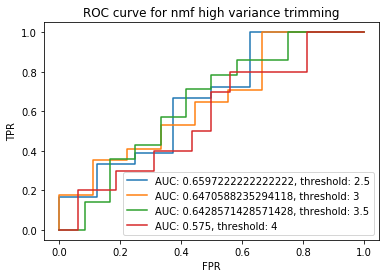

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_var:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_var]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf high variance trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

### QUESTION 9: Interpreting the NMF model

In [ ]:
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
train_nmf, test_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
nmf_model = NMF(n_factors=20,verbose=False).fit(train_unpop_nmf)

In [ ]:
U, V = nmf_model.pu, nmf_model.qi

In [ ]:
V.shape

(9373, 20)

In [ ]:
for i in range(5):
    col = V[:, i]
    top_10_indices = [t[0] for t in sorted(zip(list(range(9360)), col), key=lambda x: x[1], reverse=True)][:10]
    print('-------------------')
    print('For column {}, top 10 movie genres are:'.format(i))
    genres_list = []
    for idx in top_10_indices:
        cur_genres = df_movie.iloc[idx]['genres']
        print(cur_genres)
        genres_list += cur_genres.split('|')
    top_3_genres = [t[0] for t in Counter(genres_list).most_common(3)]
    print("The 3 most frequent genres in this column are " + ", ".join(top_3_genres))

-------------------
For column 0, top 10 movie genres are:
Comedy
Drama|Thriller
Drama|Romance
Comedy
Children|Comedy|Romance|Sci-Fi
Drama
Drama|Mystery
Drama|War
Comedy
Comedy
The 3 most frequent genres in this column are Comedy, Drama, Romance
-------------------
For column 1, top 10 movie genres are:
Comedy|Drama
War
Children|Comedy|Drama
Drama
Documentary
Comedy
Drama|Fantasy
Comedy|Fantasy|Romance
Comedy
Action|Drama
The 3 most frequent genres in this column are Comedy, Drama, Fantasy
-------------------
For column 2, top 10 movie genres are:
Drama|Horror|Mystery|Thriller
Drama|Romance
Horror|Thriller
Comedy|Romance
Drama|Romance
Drama
Comedy|Drama|Romance
Drama
Comedy|Horror
Drama|War
The 3 most frequent genres in this column are Drama, Romance, Horror
-------------------
For column 3, top 10 movie genres are:
Action|Adventure|Sci-Fi
Comedy
Comedy
Documentary|IMAX
Comedy|Romance
Comedy
Documentary|War
Comedy|Drama|Fantasy
Comedy|Romance
Action|Animation|Children|Comedy
The 3 most

The genres of the first five columns are reported as above. As we can see, Drama and Comedy are very frequent no matter what in these columns, but we do observe that besides these two common genres there are other genres in high ranking in respective columns: Sci-Fi, Horror, Romance and Thriller. We expect that each column represents the probability that a movie belongs to this genre and the above results correspond to our expectation because for top 10 movies in each column, they do belong to a certain small collection of genres. 

### QUESTION 10: Designing the MF Collaborative Filter

#### A: Design a MF-based collaborative filter

In [12]:
k_nmf_range = np.arange(2, 52, 2)
mf_avg_rmse = []
mf_avg_mae = []

for k in tqdm(k_nmf_range):
  result = cross_validate(NMF(n_factors=k, biased=True, verbose=False), data=ratings_dataset, measures=['RMSE', 'MAE'], cv=10)
  mf_avg_rmse.append(np.mean(result['test_rmse']))
  mf_avg_mae.append(np.mean(result['test_mae']))

100%|██████████| 25/25 [35:10<00:00, 84.40s/it] 


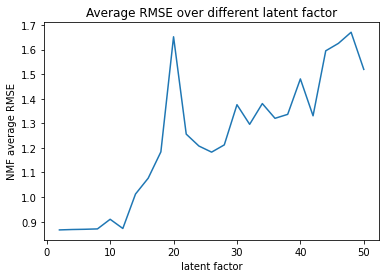

In [16]:
plot_line(x=k_nmf_range, y=mf_avg_rmse, xlabel="latent factor", 
          ylabel="NMF average RMSE", title="Average RMSE over different latent factor")

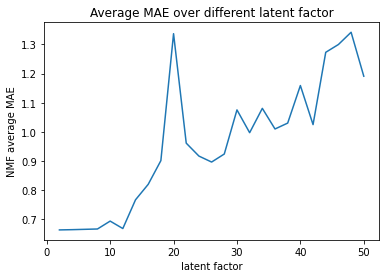

In [17]:
plot_line(x=k_nmf_range, y=mf_avg_mae, xlabel="latent factor", 
          ylabel="NMF average MAE", title="Average MAE over different latent factor")

#### B: Use the plot from the previous part to find the optimal number of latent factors

In [ ]:
rmse_min_index = mf_avg_rmse.index(min(mf_avg_rmse))
mae_min_index = mf_avg_mae.index(min(mf_avg_mae))

print("the minimum NMF RMSE is: ", min(mf_avg_rmse), " and the optimum number of latent factors are: ", k_nmf_range[rmse_min_index])
print("the minimum NMF MAE is: ", min(mf_avg_mae), " and the optimum number of latent factors are: ", k_nmf_range[mae_min_index])

the minimum NMF RMSE is:  0.8667357494731872  and the optimum number of latent factors are:  2
the minimum NMF MAE is:  0.6633610072342029  and the optimum number of latent factors are:  2


As we can see the biased MF's optimal latent factor is not the same as number of genres.

#### C: Performance on Test set subsets

In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_pop = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_nmf_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) > 2')
    result = NMF(n_factors=k, biased=True, verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_pop.append(np.mean(rmse))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [27:53<00:00, 66.96s/it]


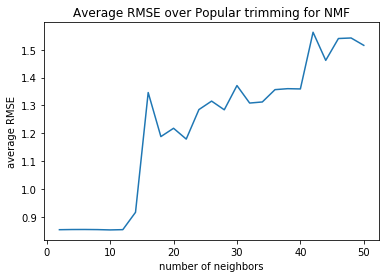

minimum average RMSE is:  0.8526982024795281


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_pop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over Popular trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_pop))

In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_unpop = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_nmf_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, 'len(dictionary[i[1]]) <= 2')
    result = NMF(n_factors=k,  biased=True, verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_unpop.append(np.mean(rmse))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


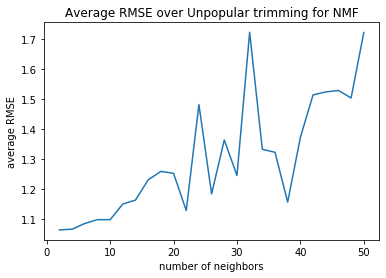

minimum average RMSE is:  1.0634714468103206


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_unpop, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over Unpopular trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_unpop))

In [ ]:
kf = KFold(n_splits=10)
nmf_avg_rmse_var = []
dictionary = load_dictionary(ratings_dataset)

for k in tqdm(k_nmf_range):
  rmse = []
  for train, test in kf.split(ratings_dataset):
    trimmed_test = trim_test(test, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
    result = NMF(n_factors=k, biased=True, verbose=False).fit(train).test(trimmed_test)
    rmse.append(accuracy.rmse(result, verbose=False))

  nmf_avg_rmse_var.append(np.mean(rmse))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [35:52<00:00, 86.12s/it]


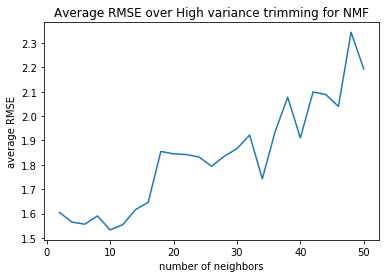

minimum average RMSE is:  1.5330329176690203


In [ ]:
plot_line(x=k_nmf_range, y=nmf_avg_rmse_var, xlabel="number of neighbors", ylabel="average RMSE", title="Average RMSE over High variance trimming for NMF")

print("minimum average RMSE is: ", min(nmf_avg_rmse_var))

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_pop_nmf, test_pop_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_pop_nmf, dictionary, 'len(dictionary[i[1]]) > 2')
nmf_pred_pop = NMF(n_factors=2, biased=True, verbose=False).fit(train_pop_nmf).test(trimmed_test)

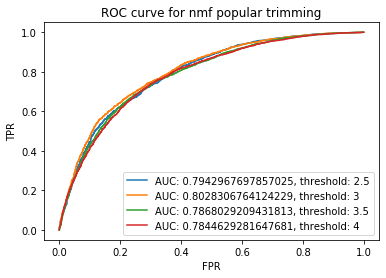

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_pop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_pop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf popular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_unpop_nmf, test_unpop_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_unpop_nmf, dictionary, 'len(dictionary[i[1]]) <= 2')
nmf_pred_unpop = NMF(n_factors=2, biased=True, verbose=False).fit(train_unpop_nmf).test(trimmed_test)

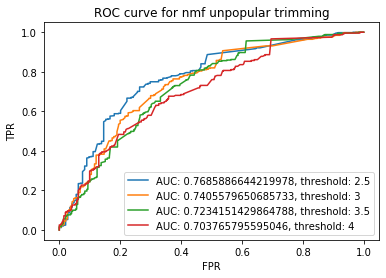

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_unpop:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_unpop]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf unpopular trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

In [ ]:
dictionary = load_dictionary(ratings_dataset)

train_var_nmf, test_var_nmf = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
trimmed_test = trim_test(test_var_nmf, dictionary, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)')
nmf_pred_var = NMF(n_factors=2, biased=True, verbose=False).fit(train_var_nmf).test(trimmed_test)

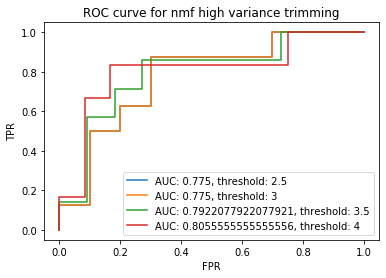

In [ ]:
for thres in threshold:
  y_true = []
  for i in nmf_pred_var:
    if(i.r_ui < thres):
      y_true.append(0)
    else:
      y_true.append(1)
  score = [i.est for i in nmf_pred_var]
  fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', threshold: ' + str(thres))

plt.legend()
plt.title('ROC curve for nmf high variance trimming')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

### QUESTION 11: Designing a Naive Collaborative Filter

#### Design a naive collaborative filter to predict the ratings of the movies in the original dataset

In [ ]:
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=10)
dictionary = load_dictionary(ratings_dataset)
user_dictionary = {}
for i in ratings_dataset.raw_ratings:
    if i[0] not in user_dictionary:
        user_dictionary[i[0]] = []
        user_dictionary[i[0]].append(i[2])
    else: 
        user_dictionary[i[0]].append(i[2])
avg_rating = {i: np.mean(user_dictionary[i]) for i in user_dictionary.keys()}

def naive_cf(dataset, avg_rating, condition=None, verbose=True):
    rmse = []
    for _, test in kf.split(dataset):
        if condition:
            test = trim_test(test, dictionary, condition)
        y_true = [t[2] for t in test]
        y_pred = [avg_rating[t[0]] for t in test]
        rmse.append(mean_squared_error(y_true, y_pred))
    avg_rmse = np.mean(rmse)
    if verbose:
        print(rmse)
        print("Average RMSE is {}".format(avg_rmse))
    return avg_rmse

_ = naive_cf(ratings_dataset, avg_rating)


[0.8837280905924303, 0.8778182831700404, 0.8684392961449247, 0.8459343607955616, 0.8729834662276268, 0.8725460926708296, 0.8805381620769551, 0.8719141158094128, 0.8869931202693432, 0.8762801655234196]
Average RMSE is 0.8737175153280544


#### Performance on Test set subsets

In [ ]:
print("For the popular sub test set, rmse is {}".format(
    naive_cf(ratings_dataset, avg_rating, 'len(dictionary[i[1]]) > 2', verbose=False)))
print("For the unpopular sub test set, rmse is {}".format(
    naive_cf(ratings_dataset, avg_rating, 'len(dictionary[i[1]]) <= 2', verbose=False)))
print("For the high variance sub test set, rmse is {}".format(
    naive_cf(ratings_dataset, avg_rating, '(len(dictionary[i[1]]) >= 5 and np.var(dictionary[i[1]]) >= 2)', verbose=False)))

For the popular sub test set, rmse is 0.8692626093122874
For the unpopular sub test set, rmse is 0.9431702404217208
For the high variance sub test set, rmse is 2.210248360889428


### QUESTION 12: Comparing the most performant models across architecture

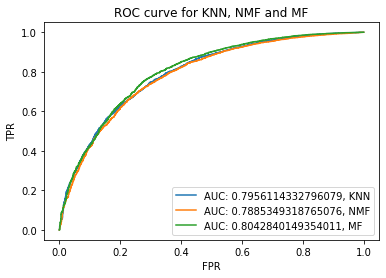

In [ ]:
dictionary = load_dictionary(ratings_dataset)
train, test = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
test = trim_test(test, dictionary, 'len(dictionary[i[1]]) > 2')

knn_pred = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train).test(test)
nmf_pred = NMF(n_factors=20, verbose=False).fit(train).test(test)
biased_pred = NMF(n_factors=2, biased=True, verbose=False).fit(train).test(test)

pred_list = [(knn_pred, "KNN"), (nmf_pred, "NMF"), (biased_pred, "MF")]

for p in pred_list:
    pred = p[0]
    name = p[1]
    y_true = []
    for i in pred:
        if(i.r_ui < 3):
          y_true.append(0)
        else:
          y_true.append(1)
    score = [i.est for i in pred]
    fpr, tpr, thresholds = metrics.roc_curve(y_true, score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC: ' + str(auc) + ', ' + name)

plt.legend()
plt.title('ROC curve for KNN, NMF and MF')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show() 

As shown in the graph, all three filters have similar performance with MF has the biggest AUC.

### QUESTION 13: Understanding Precision and Recall in the context of Recommender Systems

The intersection of $S(t)$ and $G$ can be intepreted as the set of items which are recommended by the system and are liked by the user. Therefore, the precision can be understood as the percentage of valid recommendations (i.e. valid recommendations over total recommendations), and the recall can be explained as the percentage of recommendations relevant to the user's taste (i.e. valid recommendations over user's liked items). 

### QUESTION 14: Comparing the precision-recall metrics for the different models

#### Plot Average Precision and Recall

In [ ]:
def get_metrics(pred, G, t, ur):
    S = {}
    for p in pred:
        if p.uid in S.keys():
            continue
        cur_user = set()
        for k in pred:
            if p.uid == k.uid:
                cur_user.add((k.iid, k.est))
        cur_user = sorted(list(cur_user), key=lambda x: x[1], reverse=True)[:t]
        S[p.uid] = [c[0] for c in cur_user]
    
    precision, recall = [], []
    for i in S:
        g = G[i]
        s = S[i]
        if len(g) == 0 or len(ur[i]) < t: continue
        intersection = list(set(g) & set(s))
        precision.append(len(intersection) / float(len(s)))
        recall.append(len(intersection) / float(len(g)))
    return np.mean(precision), np.mean(recall)

In [ ]:
t_list = list(range(1, 26))
kf = KFold(n_splits=10)

G = {}
full_train = ratings_dataset.build_full_trainset()
for u in full_train.ur:
    ratings = full_train.ur[u]
    G[full_train.to_raw_uid(u)] = [full_train.to_raw_iid(i[0]) for i in ratings if i[1] > 3]

res_list = []
for t in tqdm(t_list):
    metrics_matrix = np.zeros((6, 10))
    for idx, (train, test) in enumerate(kf.split(ratings_dataset)):
        knn_pred = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train).test(test)
        nmf_pred = NMF(n_factors=20, verbose=False).fit(train).test(test)
        mf_pred = NMF(n_factors=2, biased=True, verbose=False).fit(train).test(test)
        
        metrics_matrix[0][idx], metrics_matrix[3][idx] = get_metrics(knn_pred, G, t, full_train.ur)
        metrics_matrix[1][idx], metrics_matrix[4][idx] = get_metrics(nmf_pred, G, t, full_train.ur)
        metrics_matrix[2][idx], metrics_matrix[5][idx] = get_metrics(mf_pred, G, t, full_train.ur)

    res_list.append(list(np.mean(metrics_matrix, axis=1)))

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:14:24<00:00, 178.56s/it]


In [ ]:
print(np.array(res_list))

[[0.77305763 0.76788188 0.77323678 0.02099692 0.02095456 0.02082451]
 [0.76183164 0.75248707 0.76071649 0.03767955 0.03728921 0.03752471]
 [0.74483301 0.7400041  0.74741128 0.05013058 0.04959908 0.05016039]
 [0.73419487 0.73101688 0.73697623 0.05906416 0.05880859 0.05921641]
 [0.72597399 0.72113257 0.72636986 0.06595276 0.06560613 0.06597077]
 [0.71771895 0.71414158 0.71816869 0.07073722 0.07046476 0.07076391]
 [0.71238899 0.70921247 0.71258117 0.07444482 0.074246   0.07454559]
 [0.70767787 0.70454461 0.70833231 0.07807755 0.07777263 0.07811225]
 [0.70299531 0.70042698 0.70388179 0.08038813 0.08010562 0.08043988]
 [0.69931331 0.69754772 0.69917401 0.08264155 0.08248725 0.08266553]
 [0.69690968 0.69464007 0.6973947  0.08450749 0.08424731 0.08453856]
 [0.69226129 0.69072607 0.69227695 0.08607168 0.08582249 0.08604063]
 [0.69190429 0.6906759  0.69209625 0.08755563 0.08741349 0.08759986]
 [0.68605348 0.68387374 0.68650431 0.08868082 0.08846863 0.08871762]
 [0.68853289 0.68721162 0.68867367

In [ ]:
res_list = np.array(res_list)

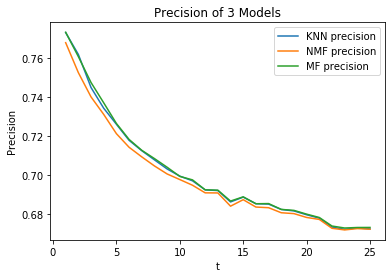

In [ ]:
plt.plot(t_list, res_list[:, 0], label='KNN precision')
plt.plot(t_list, res_list[:, 1], label='NMF precision')
plt.plot(t_list, res_list[:, 2], label='MF precision')
plt.legend()
plt.title("Precision of 3 Models")
plt.xlabel("t")
plt.ylabel("Precision")
plt.show()

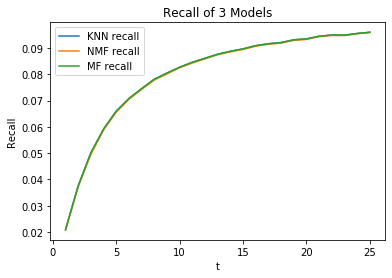

In [ ]:
plt.plot(t_list, res_list[:, 3], label='KNN recall')
plt.plot(t_list, res_list[:, 4], label='NMF recall')
plt.plot(t_list, res_list[:, 5], label='MF recall')
plt.legend()
plt.title("Recall of 3 Models")
plt.xlabel("t")
plt.ylabel("Recall")
plt.show()

#### Plot precision-recall curve

In [ ]:
dictionary = load_dictionary(ratings_dataset)
train, test = train_test_split(ratings_dataset, train_size=0.9, test_size=0.1)
test = trim_test(test, dictionary, 'len(dictionary[i[1]]) > 2')

knn_pred = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(train).test(test)
nmf_pred = NMF(n_factors=20, verbose=False).fit(train).test(test)
biased_pred = NMF(n_factors=2, biased=True, verbose=False).fit(train).test(test)

pred_list = [(knn_pred, "KNN"), (nmf_pred, "NMF"), (biased_pred, "MF")]

for p in pred_list:
    pred = p[0]
    name = p[1]
    y_true = []
    for i in pred:
        if(i.r_ui < 3):
          y_true.append(0)
        else:
          y_true.append(1)
    score = [i.est for i in pred]
    precision, recall, _ = metrics.precision_recall_curve(y_true, score, pos_label=1)
    plt.plot(precision, recall, label=name)

plt.legend()
plt.title('Precision-recall curve for KNN, NMF and MF')
plt.xlabel('precision')
plt.ylabel('recall')
plt.show() 